In [4]:
# PCA imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [5]:
# Doc2Vec imports
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim

import json # to open our data file
DATA_FILENAME = "trend_analisys.json"
# open json file
with open(DATA_FILENAME, "r") as json_file:
    json_data = json.load(json_file)
# we're expecting a list now, since our json file is a json array
assert type(json_data) is list

## Version 1 - Training Model with Abstract field (whole text)

In [6]:
# we have our json data now, let's go ahead and divide into training and test set
n_examples =  len(json_data)
# how much of the data we're going to be using for training and for testing
# default values: 80% train, 20% test
TRAIN_DATA_LENGTH = 8 * n_examples // 10
TEST_DATA_LENGTH = n_examples - TRAIN_DATA_LENGTH
ABSTRACT_FIELD_NAME = 'abstract'
TITLE_FIELD_NAME = 'title'

print("Total examples: {0}, number of train examples: {1}, number of test examples: {2}".format(n_examples,TRAIN_DATA_LENGTH, TEST_DATA_LENGTH))

# TODO: Randomize selection of examples, don't just take the first ones
# build training corpus: take the needed abstract, preprocess them (tokenize, delete spaces..)
# and create the TaggedDocument needed for training
# also added title to it 
train_corpus = [gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(
    d[TITLE_FIELD_NAME]+d[ABSTRACT_FIELD_NAME]), [i]) for i, d in enumerate(json_data) if i<TRAIN_DATA_LENGTH]
assert len(train_corpus)==TRAIN_DATA_LENGTH
print(train_corpus[:1])

Total examples: 293, number of train examples: 234, number of test examples: 59
[TaggedDocument(words=['lg', 'thinq', 'super', 'schermo', 'audio', 'al', 'top', 'lo', 'smartphone', 'che', 'ha', 'ben', 'poco', 'da', 'invidiare', 'repubblica', 'itil', 'mercato', 'degli', 'smartphone', 'si', 'fa', 'ogni', 'giorno', 'più', 'ricco', 'le', 'possibilità', 'di', 'scelta', 'tra', 'prodotti', 'di', 'buon', 'ottima', 'qualità', 'prezzi', 'diversi', 'sono', 'in', 'costante', 'crescita', 'certamente', 'tra', 'gli', 'smartphone', 'che', 'vi', 'consigliamo', 'prendere', 'in', 'considerazione', 'tra', 'quelli', 'usciti', 'di', 'recente', 'il', 'thinq', 'di', 'lg', 'sottile', 'elegante', 'il', 'modello', 'che', 'abbiamo', 'provato', 'aveva', 'un', 'elegantissimo', 'colore', 'blu', 'comodo', 'di', 'dimensioni', 'giuste', 'il', 'thinq', 'ha', 'tutte', 'le', 'caratteristiche', 'necessarie', 'per', 'accontentare', 'anche', 'il', 'pubblico', 'più', 'esigente', 'mobile', 'platform', 'qualcomm', 'snapdragon', 

In [7]:
# create the doc2vec model
# TODO: tune this parameters (personally, I think we could use a bigger vec_size, like 50)
max_epochs = 300
vec_size = 35
alpha = 0.030
MODEL_NAME = "d2v_trend_analisys_model.model"

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha,
                min_alpha=0.00030,
                min_count=2, # words that appear less than twice in the corpus are ignored
                dm=0) #dm=0 means "distributed bag of words"
# build our vocabulary of words (all the unique words encountered inside our corpus, needed for training)
model.build_vocab(train_corpus)

# train the model on the given data!
for epoch in range(max_epochs):
    if(epoch%50==0):
        print('iteration {0}'.format(epoch))
    model.train(train_corpus,
                total_examples = model.corpus_count,
                epochs = model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save(MODEL_NAME)
print("Model Saved")


iteration 0
iteration 50
iteration 100
iteration 150
iteration 200
iteration 250
Model Saved


## Visualizing Data
credits: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [8]:
# let's try to visualize all document_vectors
# get all vectors of documents we created from model training
docs_vecs = []
# docvecs (list of Doc2VecKeyedVectors) 
# – Vector representations of the documents in the corpus. Each vector has size == vector_size
for doc in iter(range(0, len(model.docvecs))):
    docs_vecs.append(model.docvecs[doc])

# loading dataset into Pandas DataFrame
df = pd.DataFrame.from_records(docs_vecs)
df.head()

#df[['target']]

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,-1.036411,-0.471695,0.985462,0.121885,-1.509385,-1.780442,0.253056,1.288514,0.008162,-2.751281,...,-0.922029,1.036483,-0.762062,-0.171672,1.354036,-1.691201,1.535649,-1.938937,0.728387,0.308307
1,-1.002666,0.631258,1.242575,-0.020710,-1.908938,0.073286,0.261581,2.220504,0.082967,-0.982622,...,-0.488178,-0.240992,-0.045239,0.862342,0.778172,-1.066683,1.737790,-1.315673,0.645655,0.236962
2,-0.798958,-0.867661,-0.813422,-0.254613,-0.376419,-1.358565,-0.166472,3.186065,-0.818461,-2.227815,...,-2.075448,-0.109493,1.078200,-0.236366,0.813869,-1.328317,0.526827,-1.776519,0.830128,1.600801
3,-1.703217,-0.398729,0.617921,-0.296285,-0.628757,-0.844446,0.705122,1.967232,-1.418087,-1.924091,...,-0.161509,-0.876871,-1.238790,0.189565,1.414227,-1.455331,0.824922,-0.058508,0.316247,2.252658
4,-1.911989,-0.235359,0.850458,-0.001770,-0.884877,0.237106,0.535283,1.375460,-1.692155,-2.690405,...,-0.630424,0.598467,-1.977885,-1.217501,1.126007,-2.228561,0.192301,-0.852016,0.496185,1.194476


In [9]:
# PCA is effected by scale so you need to scale the features in your data before applying PCA. 
features = [i for i in range(vec_size)]

x = df.loc[:, features].values # get features values
print(x)
# we don't have target here y = df.loc[:,['target']].values # get target values (guess kind of flower/Iris)

# standardize data
x = StandardScaler().fit_transform(x) # scale data (especially in case different measures are used)
# pd.DataFrame(data = x, columns = features).head() # show first data


[[-1.03641129 -0.47169518  0.98546171 ... -1.93893731  0.72838736
   0.3083069 ]
 [-1.00266635  0.63125813  1.24257505 ... -1.31567311  0.64565468
   0.23696166]
 [-0.79895782 -0.86766064 -0.81342185 ... -1.7765187   0.83012837
   1.60080111]
 ...
 [-4.22736788  1.49368644  0.71316183 ... -0.64865386  1.54141283
  -0.19890718]
 [-2.20488477  0.05373141  1.15015066 ... -1.35615087  0.83928412
   1.01590919]
 [-2.61106467 -0.15241262  0.93975186 ... -1.68420935  1.50258148
   1.18974316]]


## 2D Projection with PCA

In [10]:
# build PCA model in 2D
pca = PCA(n_components=2) # The new components are just the two main dimensions of variation.

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()
# these components drawn don't hold a lot of information 'per-se', they're just the result 
# of dimension-reduction

,principal component 1,principal component 2
0,0.813956,0.280144
1,0.881879,0.442636
2,0.469896,1.762570
3,1.049223,0.340751
4,0.784798,-0.570425


Number of points shown  234


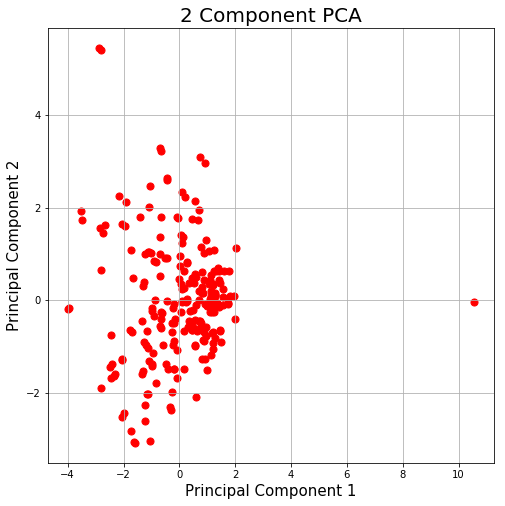

In [11]:
# we can now visualize the data by plotting them

# finalDf is the final DataFrame before plotting the data (nothing great, just taking result of PCA and attaching target to it)
#finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

finalDf = principalDf # we don't have targets to show

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

ax.scatter(finalDf.loc[:, 'principal component 1']
          , finalDf.loc[:,'principal component 2']
          , c = 'r'
          , s = 50)

#targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
#colors = ['r', 'g', 'b']
#for target, color in zip(targets, colors):
#    indicesToKeep = finalDf['target'] == target
#    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
#               , finalDf.loc[indicesToKeep, 'principal component 2']
#               , c = color
#               , s = 50)
#ax.legend(targets)
ax.grid()
print("Number of points shown ", len(finalDf))



## Visualizing Data interactively with Plotly

In [12]:
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go

tls.set_credentials_file(username='D4nt3', api_key='FdMB4O6qCfciGDOnLvdQ')

In [13]:
# we'll draw a scatter graph with labels
traces = []
# let's get the labels
titles = [dictionary[TITLE_FIELD_NAME] for i, dictionary in enumerate(json_data) if i<TRAIN_DATA_LENGTH]
# double check to be sure we got labels just right
#i = 50
#print("TITLE: {0}\n <<{1}>>".format(titles[i], train_corpus[i][:1]))

# each trace will represent a point (squeezed vector from higher dimensions),
# and each point will have the title of the news assigned
for i in range(len(finalDf)):
    trace0 = go.Scatter(
        x = finalDf.loc[i:i, "principal component 1"],
        y = finalDf.loc[i:i, "principal component 2"],
        mode = 'markers',
        #name = 'blue markers',
        marker = dict(
            size = 7,
            color = 'rgba(0, 0, 110, .8)',
        ),
        text = str(titles[i])
    )
    traces.append(trace0)

data = traces 
layout = dict(title = 'PCA Representantion of DocVectors',
        hovermode= 'closest',
        xaxis= dict(
            title= 'first component',
            ticklen= 5,
            gridwidth= 2,
        ),
        yaxis=dict(
            title= 'second component',
            ticklen= 5,
            gridwidth= 2,
        ),
        showlegend = False
    )
# Plot and embed in ipython notebook!
fig = dict(data = data, layout = layout)
py.iplot(fig, filename='TA_model-scatter')

## Some (basic) testing

In [30]:
# let's check if the model is at least decent,
# which means: is it able to at least recognize news/documents
# it has seen in training?

# Pick a random document from the train corpus and infer a vector from the model
doc_id = random.randint(0, len(train_corpus) - 1)
##########################################
## BUG: TOKENIZE DATA FIRST!!
############################################
inferred_vector = model.infer_vector(train_corpus[doc_id].words)
similar_docs = model.docvecs.most_similar([inferred_vector], topn=3)

# show the 3 most similar document titles
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
for doc_tag, similarity in similar_docs:
    print("\nSimilar Doc-->(doctag:{0},score:{1}):<<{2}>>".format(doc_tag, similarity, titles[doc_tag]))

Test Document (62): «arriva assistente vocale di salesforce anche impresa si guida con voce il sole oresan francisco la voce sarà davvero la nuova interfaccia per governare processi della propria azienda in silicon valley sembrano tutti convinti come anticipato su nova anche salesforce avrà il proprio assistente vocale si chiama einstein voice vuole rendere possibile interrogare la piattaforma di crm con il linguaggio naturale einstein si aggiunge una nuova generazione di assistenti vocali per il business rispetto ai noti siri cortana alexa google assistant esistono infatti anche assistenti professionali da usare esclusivamente quasi sul posto di lavoro paradossalmente ma neanche tanto se ci si pensa nomi sono quasi gli stessi cisco spark assistant cortana eva nuance dragon ibm watson assistant ma cosa servono il senso degli assistenti specializzati visto da vicino alla presentazione ufficiale al dreamforce di san francisco einstein non sembra molto lontano dagli assistenti che conosci

/home/nick/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.

